In [42]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
  os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")


In [43]:

from langchain.chat_models import init_chat_model

llm = init_chat_model("llama-3.1-8b-instant", model_provider="groq")

In [44]:
llm.invoke("list 5 universities in Nepal")

AIMessage(content='Here are 5 universities in Nepal:\n\n1. Tribhuvan University (TU) - Located in Kirtipur, Kathmandu, it is the oldest and largest university in Nepal.\n2. Kathmandu University (KU) - Located in Dhulikhel, Kavrepalanchok, it is a private, non-profit university.\n3. Pokhara University (PU) - Located in Pokhara, Kaski, it is a private university and is known for its emphasis on research and innovation.\n4. Purbanchal University (PU) - Located in Biratnagar, Morang, it is a public university and is known for its strong programs in engineering and management.\n5. Patan Academy of Health Sciences (PAHS) - Located in Lalitpur, Lalitpur, it is a public university and is known for its strong programs in health sciences.\n\nPlease note that this is not an exhaustive list and there are many other universities in Nepal as well.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 207, 'prompt_tokens': 41, 'total_tokens': 248, 'completion_time': 0.276, '

In [45]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [46]:
#initialize the vector store
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)

In [47]:

from langchain import hub
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load and chunk contents of the blog
loader = TextLoader("expanded_descriptions.txt")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=500)
all_splits = text_splitter.split_documents(docs)


In [48]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)



    User input as a HumanMessage;
    Vector store query as an AIMessage with tool calls;
    Retrieved documents as a ToolMessage;
    Final response as a AIMessage.


In [66]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [54]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [55]:
resp = retrieve("What is the top univeristy in Boston ?")

In [56]:
resp

"Source: {'source': 'expanded_descriptions.txt'}\nContent: Boston University\nBoston University, situated in the vibrant city of Boston, United States, is a prestigious institution of higher learning that has consistently ranked among the top universities globally, currently standing at 75th position. With a rich history and a strong commitment to academic excellence, Boston University has established itself as a hub for intellectual inquiry, innovation, and discovery.\n\nAcademically, Boston University boasts an impressive array of subjects, catering to a diverse range of interests and career aspirations. The university offers a broad spectrum of programs in fields such as Other Health, Politics & International Studies, Sociology, Mechanical & Aerospace Engineering, Education, and many more. This comprehensive range of academic disciplines enables students to explore their passions and interests, while also developing a strong foundation for future success.\n\nThe university's faculty

In [57]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
   
    return {"messages": [response]}


# execute the retrieval.
tools = ToolNode([retrieve])


#g enerate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are a universities consultant for United States "
        "You only answer the queries realted to universities in America"
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [67]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

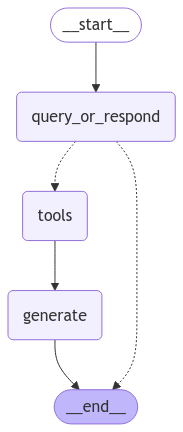

In [68]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [69]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

I'm ready to help. What would you like to know or discuss?


In [70]:
input_message = "What are some good universities in Boston?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What are some good universities in Boston?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_xcvh)
 Call ID: call_xcvh
  Args:
    query: good universities in Boston
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'expanded_descriptions.txt'}
Content: Boston University
Boston University, situated in the vibrant city of Boston, United States, is a prestigious institution of higher learning that has consistently ranked among the top universities globally, currently standing at 75th position. With a rich history and a strong commitment to academic excellence, Boston University has established itself as a hub for intellectual inquiry, innovation, and discovery.

Academically, Boston University boasts an impressive array of subjects, catering to a diverse range of interests and career

In [39]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

#id for the thread
config = {"configurable" : {"thread_id" : "test49"}}

NameError: name 'graph_builder' is not defined

In [71]:
input_message = "List 5 universities in London."

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

List 5 universities in London.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_0g50)
 Call ID: call_0g50
  Args:
    query: universities in London
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'expanded_descriptions.txt'}
Content: Overall, Pace University-New York is a dynamic and inclusive institution that offers a unique and transformative educational experience. With its strong global reputation, commitment to academic excellence, and vibrant campus life, the university is an attractive destination for students from around the world who are seeking a high-quality education and a platform for personal and professional growth.




 Bentley University
Bentley University, situated in the heart of Waltham, Massachusetts, United States, is a prestigious institution renowned for 

In [64]:
input_message = "Can you explain more about the first one ?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you explain more about the first one ?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_hyyk)
 Call ID: call_hyyk
  Args:
    query: Capital of France
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'expanded_descriptions.txt'}
Content: University of Notre Dame
The University of Notre Dame, situated in the United States, is a prestigious institution renowned for its academic excellence, vibrant campus life, and profound research impact. With a global ranking of 196, this esteemed university has established itself as a hub for intellectual curiosity and innovation.

Academically, the University of Notre Dame boasts an impressive array of subjects, catering to a diverse range of interests and career aspirations. The institution offers a broad spectrum of disciplines, including

### Simple RAG Agent using ReAct agent

In [40]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

In [24]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

NameError: name 'Image' is not defined

In [41]:
config = {"configurable": {"thread_id": "test21"}}

input_message = (
    "List 5 universities in London"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

List 5 universities in London
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_j9hs)
 Call ID: call_j9hs
  Args:
    query: universities in London
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'expanded_descriptions.txt'}
Content: Overall, Pace University-New York is a dynamic and inclusive institution that offers a unique and transformative educational experience. With its strong global reputation, commitment to academic excellence, and vibrant campus life, the university is an attractive destination for students from around the world who are seeking a high-quality education and a platform for personal and professional growth.




 Bentley University
Bentley University, situated in the heart of Waltham, Massachusetts, United States, is a prestigious institution renowned for i

In [21]:
%%capture --no-stderr
%pip install -U psycopg psycopg-pool langgraph langgraph-checkpoint-postgres

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
import os
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.postgres import PostgresSaver
from psycopg_pool import ConnectionPool
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.tools import tool
from langchain import hub
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain.chat_models import init_chat_model

# llm = init_chat_model("llama-3.3-70b-versatile", model_provider="groq")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_store = Chroma(embedding_function=embeddings)



# Load and chunk contents of the blog
loader = TextLoader("expanded_descriptions.txt")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=500)
all_splits = text_splitter.split_documents(docs)

_ = vector_store.add_documents(all_splits)



@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

from dotenv import load_dotenv
load_dotenv()
DB_URI = os.getenv("DATABASE_URL")

connection_kwargs = {
    "autocommit": True,
    "prepare_threshold": 0,
}


In [37]:
# llm = init_chat_model("llama-3.3-70b-versatile", model_provider="groq")

with ConnectionPool(conninfo=DB_URI, max_size=20, kwargs=connection_kwargs) as pool:
    checkpointer = PostgresSaver(pool)

    checkpointer.setup()

    graph = create_react_agent(llm, tools = [retrieve], checkpointer=checkpointer)

    config = {"configurable":{"thread_id" :"test_10"}}
    
    res = graph.invoke(
        {"messages": [{"role": "user", "content": "List 5 universities in London"}]},
        config
        )
    checkpoint = checkpointer.get(config)


In [38]:
res['messages']

[HumanMessage(content='List 5 universities in Boston or around it.', additional_kwargs={}, response_metadata={}, id='dd2a35f5-a02a-490d-8153-92eea15a361e'),
 AIMessage(content='<function=retrieve {"query": "universities in Boston or around it"} </function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 220, 'total_tokens': 241, 'completion_time': 0.077683005, 'prompt_time': 0.012898339, 'queue_time': 0.503000789, 'total_time': 0.090581344}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_76dc6cf67d', 'finish_reason': 'stop', 'logprobs': None}, id='run-2688b198-56d6-4864-bf58-59adaa7782f4-0', usage_metadata={'input_tokens': 220, 'output_tokens': 21, 'total_tokens': 241}),
 HumanMessage(content='List 5 universities in Boston or around it.', additional_kwargs={}, response_metadata={}, id='bf2f473c-2533-4520-b055-e978870c315c'),
 AIMessage(content='<function=retrieve {"query": "list of universities in Boston"} </funct

In [34]:
response

"content='1. Harvard University\\n2. Massachusetts Institute of Technology (MIT)\\n3. Boston University\\n4. Tufts University\\n5. Northeastern University' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 297, 'total_tokens': 328, 'completion_time': 0.113077926, 'prompt_time': 0.017738837, 'queue_time': 0.912828977, 'total_time': 0.130816763}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_5f849c5a0b', 'finish_reason': 'stop', 'logprobs': None} id='run-553f0887-8f4e-4aee-8dff-c101ce3807ab-0' usage_metadata={'input_tokens': 297, 'output_tokens': 31, 'total_tokens': 328}"

In [34]:
checkpoint

{'v': 1,
 'id': '1eff35b9-df6d-6c7b-8008-78baca13a256',
 'ts': '2025-02-25T09:33:48.954927+00:00',
 'pending_sends': [],
 'versions_seen': {'agent': {'tools': '00000000000000000000000000000009.0.3813555539647716',
   'start:agent': '00000000000000000000000000000007.0.30522680752053577'},
  'tools': {'branch:agent:should_continue:tools': '00000000000000000000000000000008.0.10467975420995534'},
  '__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000006.0.20953087306488416'}},
 'channel_versions': {'agent': '00000000000000000000000000000010.0.5332665299818378',
  'tools': '00000000000000000000000000000010.0.37935810279609206',
  'messages': '00000000000000000000000000000010.0.7181371835350833',
  '__start__': '00000000000000000000000000000007.0.5356087228750375',
  'start:agent': '00000000000000000000000000000008.0.28151541301491956',
  'branch:agent:should_continue:tools': '00000000000000000000000000000009.0.38705983826317736'},
 'channel_values': {'agent': 'agent'